In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
%reload_ext pandas_tutor
%set_pandas_tutor_options {'projectorMode': True}
set_matplotlib_formats("svg")
plt.style.use('fivethirtyeight')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animations
from IPython.display import display, IFrame

def show_bootstrapping_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vS_iYHJYXSVMMZ-YQVFwMEFR6EFN3FDSAvaMyUm-YJfLQgRMTHm3vI-wWJJ5999eFJq70nWp2hyItZg/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 509
    display(IFrame(src, width, height))
    
def show_confidence_interval_slides():
    src="https://docs.google.com/presentation/d/e/2PACX-1vTaPZsueXI6fey_5cj2Y1TevkR1joBvpwaWVsZNvgBlnJSrw1EiBLHJywkFH_QNLU5Tdr6JZgDrhFxG/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 989
    display(IFrame(src, width, height))

# Lecture 19 – Percentiles and Confidence Intervals

## DSC 10, Summer 2022

### Announcements

- HW 5 is due **tomorrow at 11:59pm**.
- Lab 6 is due **Tuesday at 11:59pm**.

### Agenda

- Review: bootstrapping.
- Percentiles.
- Confidence intervals.

## Review: bootstrapping

**Goal:** Estimate the distribution of a sample statistic, given just a single sample.

In [2]:
show_bootstrapping_slides()

### Recall: City of San Diego salary data

- We're interested in the median of all salaries (this is our population parameter).
- In this case we know it, but in reality we will not.

In [3]:
population = bpd.read_csv('data/2020_salaries.csv')
population_median = population.get('TotalWages').median()
population_median

71354.5

### One random sample

In [11]:
np.random.seed(23) # Ignore this
my_sample = population.sample(500, replace=False).get(['TotalWages'])
my_sample

,TotalWages
9749,36727
10369,23584
8529,49460
...,...
3991,93828
8397,50704
5994,74289


In [78]:
sample_median = my_sample.get('TotalWages').median()
sample_median

69616.0

### You Try: Bootstrap the sample median

1. Simulate another sample by resampling 500 items from `my_sample` with replacement. Then, find the median of each bootstrap sample.
1. Repeat step 1 5,000 times. Store results in an array called `boot_medians`.
1. Plot a histogram of the bootstrap medians.
1. Say what your best guess for the population median is.

### Bootstrapping

In [12]:
# Note that the population DataFrame doesn't appear anywhere here!
n_resamples = 5000
boot_medians = np.array([])

for i in np.arange(n_resamples):
    
    # Resample from my_sample
    resample = my_sample.sample(500, replace=True)
    
    # Compute the median
    median = resample.get('TotalWages').median()
    
    # Store it in our array of medians
    boot_medians = np.append(boot_medians, median)

In [13]:
boot_medians

array([72979.5, 70080. , 66564.5, ..., 67976.5, 67183. , 67976.5])

Now that we have this array of bootstrapped sample medians, we can visualize it.

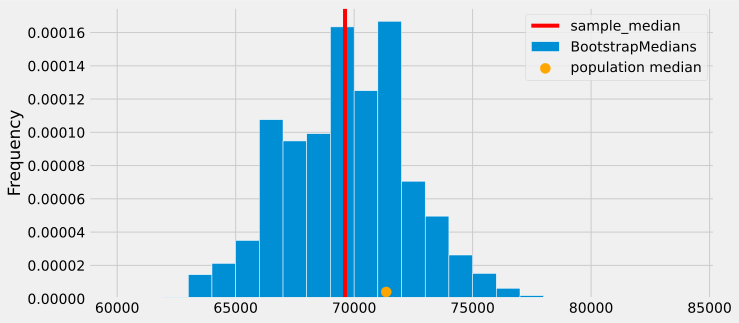

In [83]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.axvline(sample_median, c='r', label='sample_median');
plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(2)
plt.legend();

- We can only plot the orange dot because we happen to know the population parameter in this case (for teaching purposes).
    - In reality, you will not know the population parameter!
- If we just look at the bootstrap distribution, what's our best guess for the population median?
    - \\$65,000 to \\$75,000?
    - \\$68,000 to \\$72,000?
    - Something else?
- **Idea:** Find the range that captures the middle 95% of the values.

## Percentiles

### Mathematical definition

> Let $p$ be a number between 0 and 100. The $p$th percentile of a collection is the smallest value in the collection that is *at least as large* as $p$% of all the values. 

By this definition, any percentile between 0 and 100 can be computed for any collection of values and is **always an element of the collection.** 

### How to calculate percentiles using mathematical definition

Suppose there are $n$ elements in the collection. To find the $p$th percentile:

1. Sort the collection in increasing order.
2. Define $h$ to be $p\%$ of $n$: 

$$h = \frac p{100} \cdot n$$

3. If $h$ is an integer, define $k = h$. Otherwise, let $k$ be the smallest integer greater than $h$.

4. Take the $k$th element of the sorted collection (start counting from 1, not 0).

### Example

Let's say we have an array: `np.array([4, 10, 15, 21, 100, 120])`. Here's what our percentile formula does:

| data       | 4       | 10       | 15       | 21       | 100       | 120 |
|------------|---------|----------|----------|----------|-----------|-----|
| percentile | [0, 20) | [20, 40) | [40, 60) | [60, 80) | [80, 100) | 100 |

So, the 8th percentile is `4`. The 60th percentile is `21`. Etc.

- The median is the 50th percentile: `15`.
- Easiest way to remember:
    - First item in array is the 0th percentile.
    - Last item in array is the 100th percentile.
    - Split up the rest of the range evenly.
    - When you're in between two percentiles, choose the lower array item.

### You Try:

What is the 50th percentile (the median) of this array?

What about the 70th percentile?

`np.array([70, 18, 56, 89, 55, 35, 10, 45])`

### Calculating the percentile using our mathematical definition

In [37]:
def percentile(data, p):
    data = sorted(data)
    n = len(data)
    h = (p / 100) * n
    k = int(np.ceil(h)) # If h is an integer, this is h. Otherwise, rounds up.
    return data[k - 1] # -1 because Python is 0-indexed, but regular math is 1-indexed.

In [61]:
example = np.array([70, 18, 56, 89, 55, 35, 10, 45])
percentile(example, 50)

45

### Another definition of percentile

- The `numpy` package provides a function to calculate percentiles, `np.percentile(array, p)`, which returns the `p`th percentile of `array`.
- To do our definition of percentile, pass in `interpolation='lower'`.

In [62]:
np.percentile(example, 50, interpolation='lower')

45

## Confidence intervals

### Using the bootstrap distribution

- Now, let's return to our original question:
    - We have a sample median (around \\$69k).
    - This means that we think that the population median is close to \\$69k.
    - How do we capture our uncertainty about this guess?
- Idea: Find a range that captures most of the bootstrap distribution.

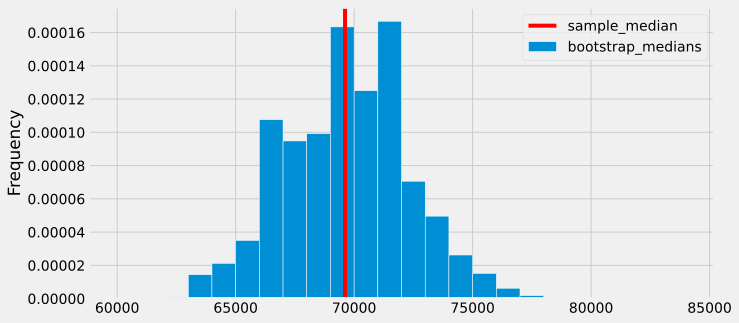

In [81]:
bpd.DataFrame().assign(bootstrap_medians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.axvline(sample_median, c='r', label='sample_median');
plt.legend();

### Confidence intervals

Let's state it using statistical lingo:

- Goal: estimate an unknown population parameter.
- We have been saying 
>"My guess for the population parameter is my sample statistic, $x$."
- We want to say 
>"My guess is that the population parameter is between $a$ and $b$."
- Let's use the bootstrapped distribution of an estimate to compute an **interval** that contains "the bulk" of the estimates.

### Finding endpoints

- We want to find two points, $x$ and $y$, such that the area:
    - to the left of $x$ is about 2.5%.
    - to the right of $y$ is about 2.5%.
- The interval $[x,y]$ will contain about 95% of the total area, i.e. 95% of the total values.
- $x$ and $y$ are the **2.5th percentile** and **97.5th percentile**, respectively.

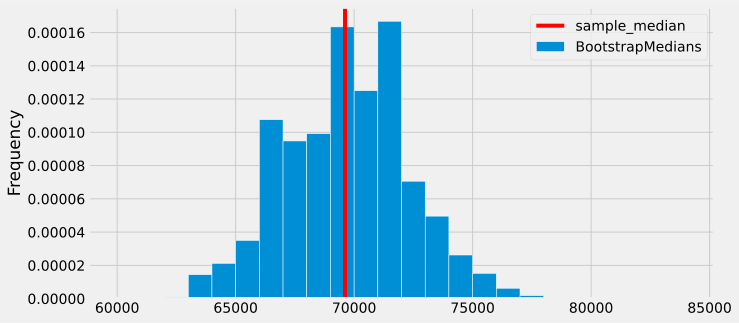

In [82]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.axvline(sample_median, c='r', label='sample_median');
plt.legend();

In [92]:
# Left endpoint
left = np.percentile(boot_medians, 2.5, interpolation='lower')
left

64638.5

In [93]:
# Right endpoint
right = np.percentile(boot_medians, 97.5, interpolation='lower')
right

74991.0

In [94]:
# Therefore, our interval is
[left, right]

[64638.5, 74991.0]

You will use the code above **very** frequently moving forward!

### Visualizing our 95% confidence interval

- Let's draw the interval we just computed on the histogram.
- 95% of the bootstrap medians fell into this interval.

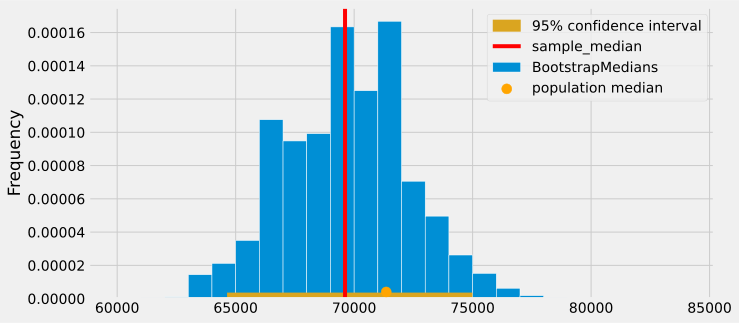

In [90]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='goldenrod', linewidth=12, label='95% confidence interval');
plt.axvline(sample_median, c='r', label='sample_median');
plt.scatter(population_median, 0.000004, color='orange', s=100, label='population median').set_zorder(3)
plt.legend();

- In this case, our 95% confidence interval (lime green) contains the true population parameter (orange dot).
    - It won't always, because you might have a bad original sample!
    - In reality, you won't know where the population parameter is, and so you won't know if your confidence interval contains it.

### You Try: Confidence levels

The code above finds the 95% confidence interval. Will the 80% confidence interval be wider or narrower than the 95% interval? Discuss with your neighbor, then write code to compute the 80% confidence interval.

Explain the pros and cons of using an 80% interval instead of a 95%.

  - You won't know how to do this exactly, but take your best guess.

In [95]:
left80 = np.percentile(boot_medians, 10, interpolation='lower')
right80 = np.percentile(boot_medians, 80, interpolation='lower')
[left80, right80]

[66305.0, 71876.0]

In [96]:
# 95% confidence
[left, right]

[64638.5, 74991.0]

## Interpreting confidence intervals

### Interpreting confidence intervals

- 95% of our bootstrap medians fell within this interval.
- We're pretty confident that the true median does, too.
- How confident should we be about this? **What does a 95% confidence interval mean?**

### Capturing the true value

- Consider the process of:
    - Collecting a **new original sample** from the population,
    - Bootstrap resampling from it many times, computing the statistic (e.g. median) in each resample, and
    - Constructing a new 95% confidence interval.
- What a 95% confidence level states is that **approximately 95% of the time, the intervals you create through this process will contain the true population parameter**.
- The confidence is in **the process** that generates the interval.

### Many confidence intervals

- We repeated the process outlined on the previous slide 200 times, to come up with 200 confidence intervals.
    - We did this in advance and saved the results to a file to save time.
- The resulting CIs are stored in the array `many_cis` below.

In [69]:
many_cis = np.load('data/many_cis.npy')
many_cis

array([[64954.12, 76985.06],
       [64961.  , 76063.  ],
       [64757.5 , 74301.96],
       ...,
       [64599.2 , 77106.36],
       [60956.57, 71571.11],
       [67632.39, 78566.41]])

In the visualization below,
- The orange line represents the population parameter. **This is not random.**
- Each green line represents a separate confidence interval, created using the specified process.
- Most of these confidence intervals contain the true parameter – but not all!

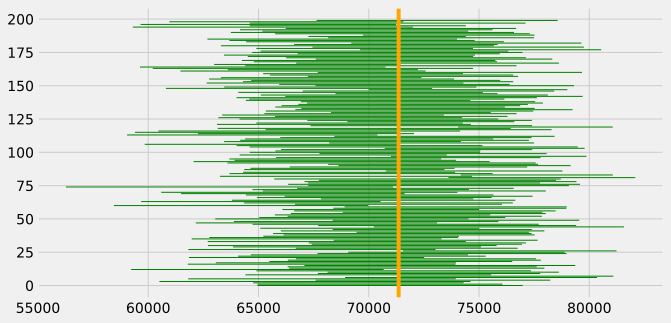

In [70]:
plt.figure(figsize=(10, 5))
for i, ci in enumerate(many_cis):
    plt.plot([ci[0], ci[1]], [i, i], color='green', linewidth=1)
plt.axvline(x=population_median, color='orange');

### Which confidence intervals don't contain the true parameter?

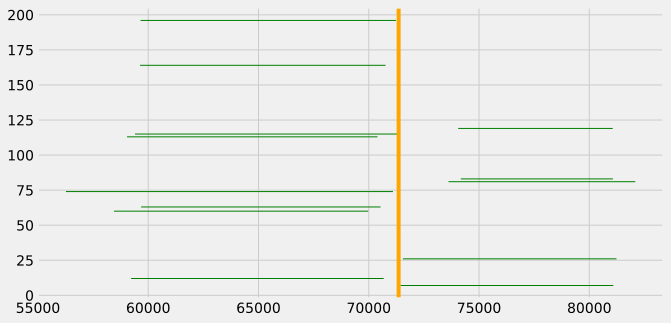

In [71]:
plt.figure(figsize=(10, 5))
count_outside = 0
for i, ci in enumerate(many_cis):
    if ci[0] > population_median or ci[1] < population_median:
        plt.plot([ci[0], ci[1]], [i, i], color='green', linewidth=1)
        count_outside = count_outside + 1
plt.axvline(x=population_median, color='orange');

In [72]:
count_outside

13

- 13 of my 200 confidence intervals didn't contain the true parameter.
- That means 187/200, or 93.5% of them, did.
    - This is pretty close to 95%!
- In reality, you will have **no way of knowing if your confidence interval contains the true parameter**, since you have no way of knowing if your original sample is good.

### Confidence Tradeoffs

- If I choose 95% confidence, about 5% of my samples will be "unlucky".
    - When I use an unlucky sample to make my CI, the CI won't contain the population parameter.
- If I choose 80% confidence, about 20% of my samples will be unlucky.
    - But, my confidence interval will be narrower, which means I'm making a more precise estimation.
- How do I have high confidence and high precision?
    - Take a big sample!

### Misinterpreting confidence intervals

- Confidence intervals are confusing. Here are a few common misconceptions.

In [73]:
# Our interval
[left, right]

[64638.5, 74991.0]

- It is **not true** that this interval contains 95% of all salaries.
- Instead, it is true that this interval contains 95% of all bootstrapped **median** salaries.

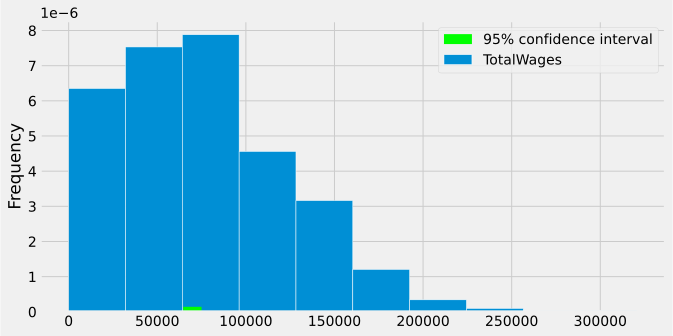

In [74]:
population.plot(kind='hist', y='TotalWages', density=True, ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='lime', linewidth=10, label='95% confidence interval');
plt.legend();

### Misinterpreting confidence intervals

In [75]:
# Our interval
[left, right]

[64638.5, 74991.0]

- It is **not true** that there is a 95% chance that the interval above contains the population parameter.
    - Once I have a sample, the interval is (essentially) fixed.
    - Either the population parameter is in the interval, or it is not. There is no randomness involved.
- Remember that the 95% confidence is in the process that created an interval.
    - This process (sampling, then bootstrapping, then creating an interval) has a roughly 95% chance of creating a good interval.
    - 95% confidence needs all three steps. Can't skip the first one!

In [76]:
show_confidence_interval_slides()

## Why does it matter?

- You probably make mental confidence intervals all the time:
- "How long does it take to drive to the airport?"
    - "Around 25-35 minutes."
- In the past week, we're making this reasoning rigorous.
- Confidence intervals are used basically whenever we're uncertain about something.
    - In engineering: when will this part break?
    - In business: how much profit will we make next month? 
    - In economics: how will the inflation rate affect markets?
- Next time: we'll connect CIs with hypothesis testing.